# **Load in the dataset** 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset/edible/Tremella_fuciformis15.png
/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset/edible/Calbovista_subsculpta25.png
/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset/edible/Tuber_brumale3.png
/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset/edible/Suillus_tomentosus26.png
/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset/edible/Boletus_badius24.png
/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset/edible/Hydnum_repandum31.png
/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset/edible/Hygrophorus_chrysodon25.png
/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset/edible/Calvatia_utriformis25.png
/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset/edible/Tuber_mesentericum24.png
/kaggle/input/m

# **Importing Libraries and Modules**

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32

# **Importing Images**

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/mushroom-pictures-dataset-edible-and-poisonous/mushroom_dataset",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 7171 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['edible', 'poisonous']

In [6]:
len(dataset)

225

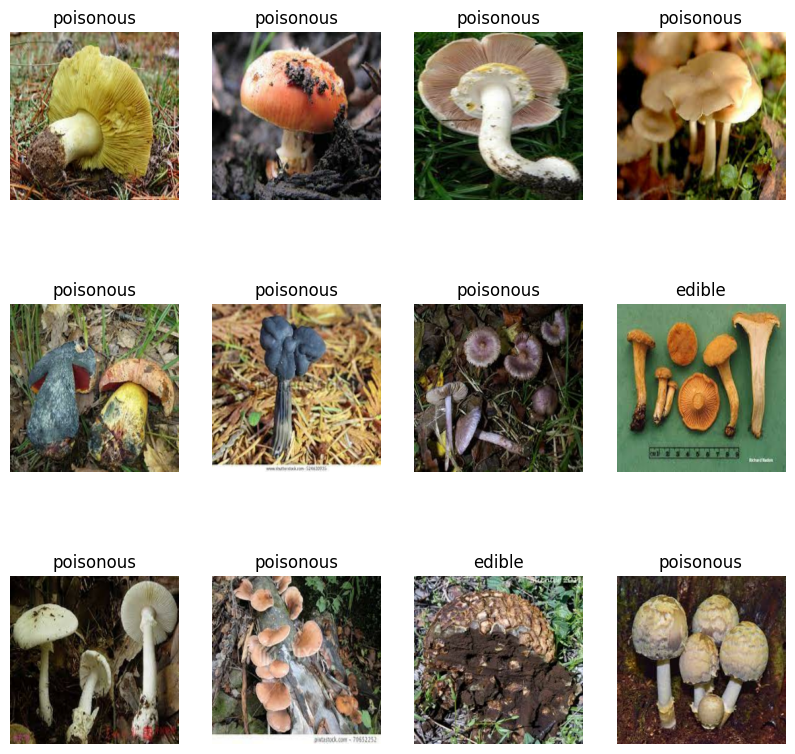

In [7]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# **Data Augmentation**

In [8]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = get_dataset(dataset)
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 180

Length of Validation Dataset is 22

Length of Testing Dataset is 23


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0 / 255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(0.2)
])

# **Model Building**

In [13]:
n_classes = 2
input_shape = (256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32,(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=(None, 256, 256, 3))

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,826 (1.06 MB)

 Trainable params: 277,826 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

# **Training The Model**

In [16]:
history = model.fit(
train_ds,
epochs=50,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.6400 - loss: 0.6472 - val_accuracy: 0.6477 - val_loss: 0.6573
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6444 - loss: 0.6487 - val_accuracy: 0.6477 - val_loss: 0.6305
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6615 - loss: 0.6246 - val_accuracy: 0.6477 - val_loss: 0.6207
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6550 - loss: 0.6302 - val_accuracy: 0.6491 - val_loss: 0.6202
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6590 - loss: 0.6231 - val_accuracy: 0.6648 - val_loss: 0.6188
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6593 - loss: 0.6225 - val_accuracy: 0.6861 - val_loss: 0.6007
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6627 - loss: 0.6147 - val_accuracy: 0.6776 - val_loss: 0.6098
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6739 - loss: 0.6051 - val_acc

In [17]:
scores = model.evaluate(test_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7685 - loss: 0.4583


In [18]:
history

In [19]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 180}

In [20]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

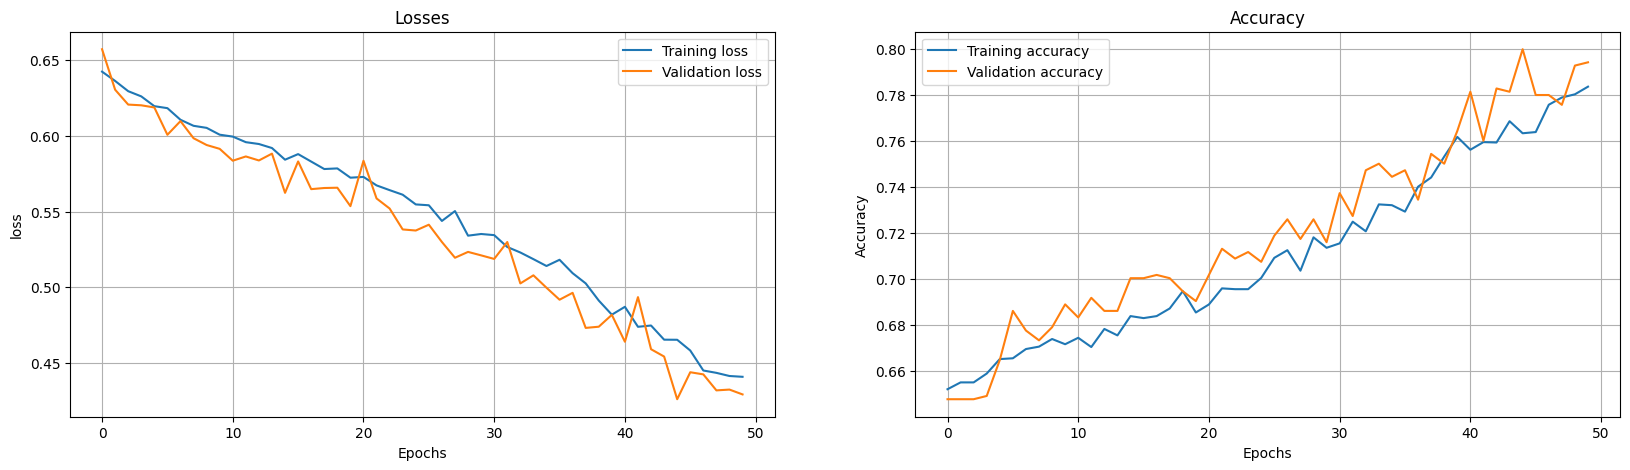

In [21]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# **Predictions**

First Image to Predict :

Actual label: edible
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

Predicted label edible


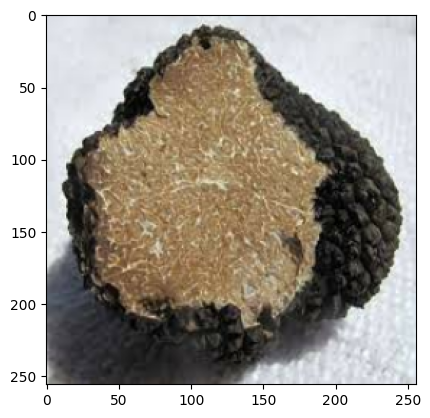

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch) 
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


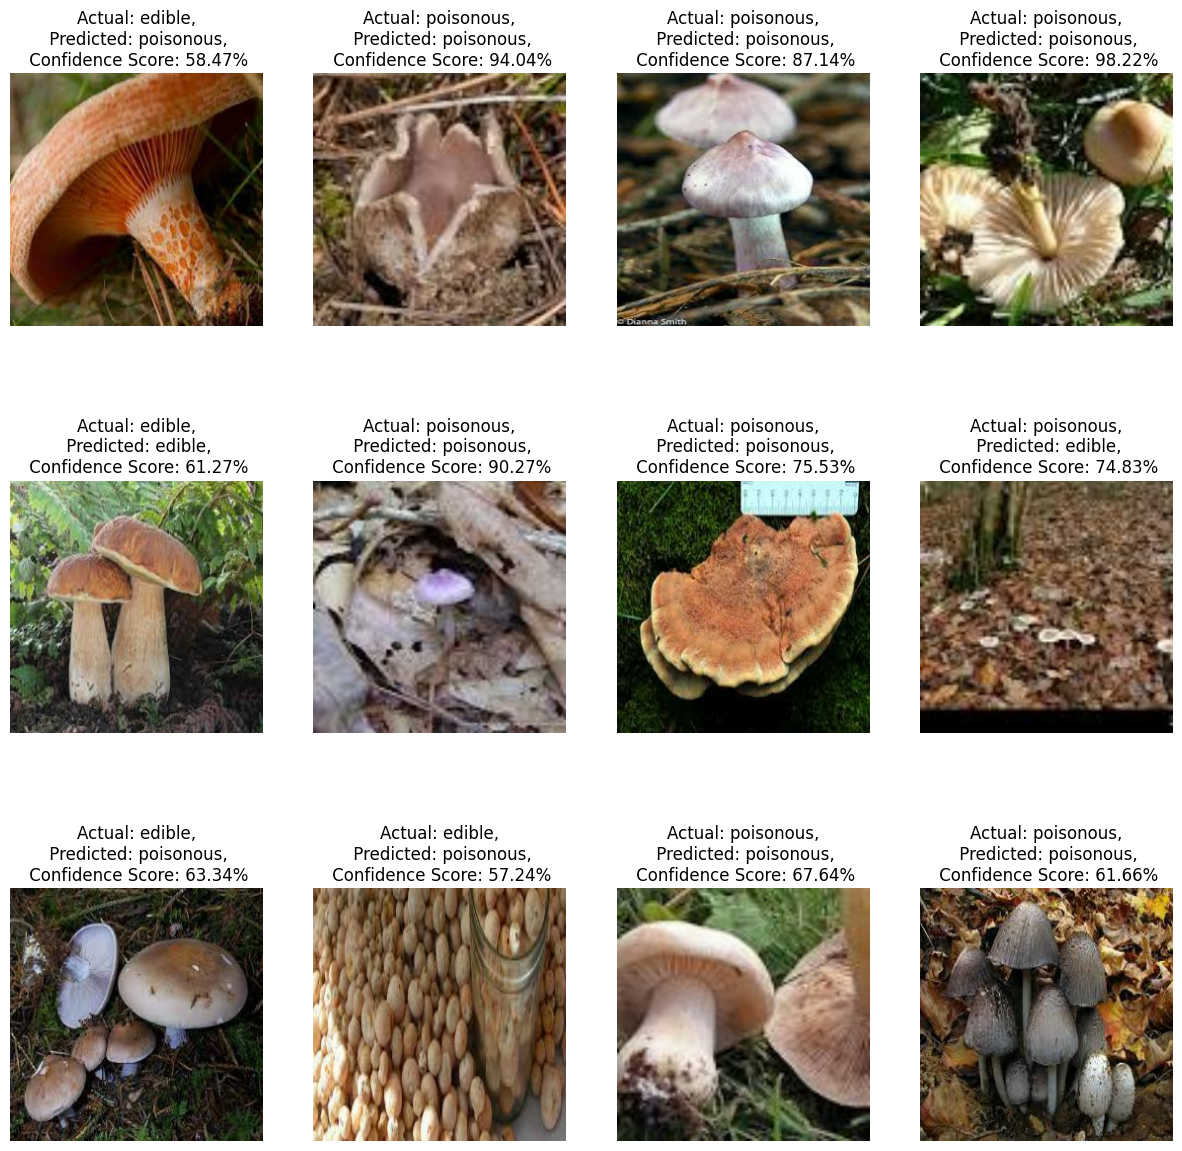

In [24]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

# **Evaluating The Model**

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# Get predictions on the test dataset
test_labels = []
test_predictions = []

In [27]:
# Iterate over the test dataset
for images, labels in test_ds:
    # Predict the class probabilities for each batch of images
    predictions = model.predict(images)
    
    # Convert predictions and true labels to class indices
    predicted_classes = np.argmax(predictions, axis=1)
    test_predictions.extend(predicted_classes)
    test_labels.extend(labels.numpy())  # Ensure labels are numpy arrays

# Convert lists to numpy arrays for compatibility with sklearn functions
test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


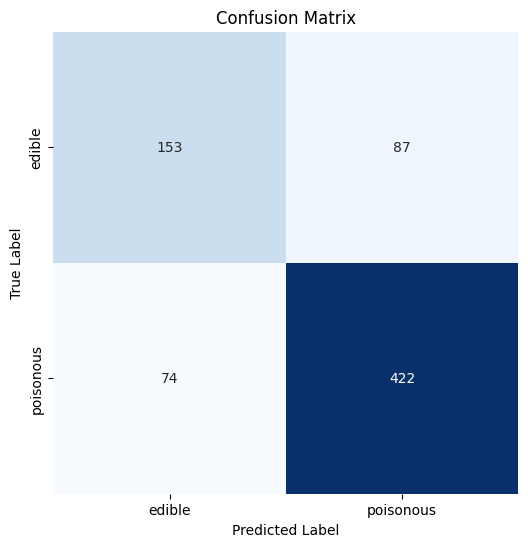

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [29]:
# Classification Report (includes F1-score)
print(classification_report(test_labels, test_predictions, target_names=class_names))

              precision    recall  f1-score   support

      edible       0.67      0.64      0.66       240
   poisonous       0.83      0.85      0.84       496

    accuracy                           0.78       736
   macro avg       0.75      0.74      0.75       736
weighted avg       0.78      0.78      0.78       736



# **Saving the Model**

In [30]:
model.save('/kaggle/working/mushroom_model_v13.keras')